In [1]:
import os

import numpy as np
import pandas as pd
import pydicom as dicom

from skimage.exposure import rescale_intensity
from typing import Union, AnyStr, BinaryIO, Optional

%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
def dcmread_image(
        fp: Union[str, 'os.PathLike[AnyStr]', BinaryIO], view: str, index: Optional[np.uint] = None
    ) -> np.ndarray:
    '''Read pixel array from DBT DICOM file'''
    ds = dicom.dcmread(fp)
    pixel_array = ds.pixel_array
    view_laterality = view[0].upper()
    image_laterality = _get_image_laterality(pixel_array[index or 0])
    if index is not None:
        pixel_array = pixel_array[index]
    if not image_laterality == view_laterality:
        pixel_array = np.flip(pixel_array, axis=(-1, -2))
    window_center = _get_window_center(ds)
    window_width = _get_window_width(ds)
    low = (2 * window_center - window_width) / 2
    high = (2 * window_center + window_width) / 2
    pixel_array = rescale_intensity(pixel_array, in_range=(low, high), out_range="dtype")
    return pixel_array

def _get_dicom_laterality(ds: dicom.dataset.FileDataset) -> str:
    '''Unreliable - DICOM laterality is incorrect for some cases'''
    return ds[0x5200,0x9229][0][0x0020, 0x9071][0][0x0020, 0x9072].value

def _get_image_laterality(pixel_array: np.ndarray) -> str:
    left_edge = np.sum(pixel_array[:, 0])  # sum of left edge pixels
    right_edge = np.sum(pixel_array[:, -1])  # sum of right edge pixels
    return 'R' if left_edge < right_edge else 'L'

def _get_window_center(ds: dicom.dataset.FileDataset) -> np.float32:
    return np.float32(ds[0x5200,0x9229][0][0x0028, 0x9132][0][0x0028, 0x1050].value)

def _get_window_width(ds: dicom.dataset.FileDataset) -> np.float32:
    return np.float32(ds[0x5200,0x9229][0][0x0028, 0x9132][0][0x0028, 0x1051].value)

In [3]:
def read_bboxes(bboxes_fp: pd._typing.FilePathOrBuffer, filepaths_fp: pd._typing.FilePathOrBuffer) -> pd.DataFrame:
    df_bboxes = pd.read_csv(bboxes_fp)
    df_filepaths = pd.read_csv(filepaths_fp)
    primary_key = ['PatientID', 'StudyUID', 'View']
    if not all([key in df_bboxes.columns for key in primary_key]):
        raise AssertionError(
            f'Not all primary key columns {primary_key} are present in bounding boxes columns {df_bboxes.columns}'
        )
    if not all([key in df_bboxes.columns for key in primary_key]):
        raise AssertionError(
            f'Not all primary key columns {primary_key} are present in file paths columns {df_filepaths.columns}'
        )
    df = pd.merge(df_bboxes, df_filepaths, on=primary_key)
    return df

In [4]:
df = read_bboxes(bboxes_fp='/data/bboxes.csv', filepaths_fp='/data/file_paths.csv')

In [5]:
pid = 'DBT-P00013'
view_series = df[df['PatientID'] == pid].iloc[0]
image_path = os.path.join('/data', view_series['descriptive_path'])
view = view_series['View']
slice_index = view_series['Slice']

In [6]:
%%time
image = dcmread_image(fp=image_path, view=view, index=slice_index)

CPU times: user 27.4 s, sys: 1.02 s, total: 28.4 s
Wall time: 28.5 s


/usr/local/lib/python3.8/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:176: UserWarning: The (0028,0101) 'Bits Stored' value (10-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


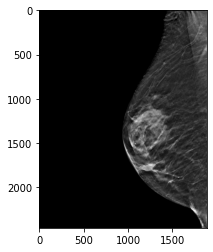

In [7]:
plt.imshow(image, cmap=plt.cm.gray);

In [8]:
# bounding box definition
x, y, w, h = view_series[['X', 'Y', 'Width', 'Height']]
x, y, w, h

(555, 1724, 218, 105)